In [11]:
import numpy as np
from scipy.signal import cont2discrete
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import safe_learning
import plotting

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

In [12]:
def uniform_state_sampler(n_samples, domain, scaling=None):
    """
    Samples uniformly from a box in the state space.
    """
    dim_state = len(domain)
    n_samps = int(n_samples)
    for i in range(dim_state):
        delta = domain[i][1]-domain[i][0]
        offset = domain[i][0]
        single_dim = delta*np.random.rand(n_samps, 1) + offset
        if scaling is not None:
            single_dim = single_dim / scaling[i]
        if i == 0:
            samples = single_dim
        else:
            samples = np.concatenate((samples, single_dim), axis=1)
    return samples

In [13]:
# %% Linearized cart-pole system

# System parameters
m = 10      # pendulum mass
M = 10      # cart mass
L = 100       # pole length
g = 9.81    # gravitational constant

# Linearized continuous-time system matrices for state vector:
# s = (q, q_dot) = (x, theta, x_dot, theta_dot)
dim_state = 4
dim_input = 1
A = np.array([[0, 0,             1, 0],
              [0, 0,             0, 1],
              [0, g*m/M,         0, 0],
              [0, g*(m+M)/(L*M), 0, 0]])
B = np.array([0, 0, 1/M, 1/(M*L)]).reshape(-1, dim_input)

# Discretized system matrices
Ts = 0.01    # sampling time
Ad, Bd, _, _, _ = cont2discrete((A, B, 0, 0), Ts, method='zoh')

# Domain and scaling
x_max = 10
theta_max = np.deg2rad(45)
x_dot_max = 5
u_max = g*m*theta_max
theta_dot_max = (g*(m+M)*theta_max + u_max)/(M*L)

domain = [[-x_max, x_max], [-theta_max, theta_max],
          [-x_dot_max, x_dot_max], [-theta_dot_max, theta_dot_max]]
state_scaling = [x_max, theta_max, x_dot_max, theta_dot_max]
action_scaling = [u_max]

Ts = np.diag(state_scaling)
Tu = np.diag(action_scaling)
Ts_inv = np.diag([1/i for i in state_scaling])
Tu_inv = np.diag([1/i for i in action_scaling])
A_scl = Ts_inv.dot(A).dot(Ts)
B_scl = Ts_inv.dot(B).dot(Tu)

In [14]:
# Cost matrices and exact value function

# State cost matrix
Q = 2*np.identity(dim_state)

# Input cost matrix
R = np.identity(dim_input)

# Solve Lyapunov equation for the exact value function and optimal feedback law u = -K.dot(x)
K, P = safe_learning.utilities.dlqr(A_scl, B_scl, Q, R)

In [15]:
# TensorFlow functions for the cost function and the scaled, discretized, linearized dynamics

@safe_learning.utilities.with_scope('cost_function')
def cost_function(states, actions):
    costs = tf.reduce_sum(tf.matmul(states, Q)*states + tf.matmul(actions, R)*actions,
                          axis=1,
                          keep_dims=True)
    return costs


@safe_learning.utilities.with_scope('dynamics')
def dynamics(states, actions):
    future_states = tf.matmul(states, A_scl.T) + tf.matmul(actions, B_scl.T)
    return future_states

In [16]:
# Function approximators

# Value function
layer_dims = [64, 64, 1]
activations = [tf.nn.relu, tf.nn.relu, None]
value_function = safe_learning.functions.NeuralNetwork(layer_dims,
                                                       activations,
                                                       name='value_function')

# Policy
layer_dims = [1]
activations = [None]
# initializer = tf.constant_initializer(-K.T)
initializer = tf.contrib.layers.xavier_initializer()
policy = safe_learning.functions.NeuralNetwork(layer_dims,
                                               activations,
                                               name='policy')

In [17]:
# States, actions, stage costs, and values

tf.reset_default_graph()
dtype = safe_learning.config.dtype

states = tf.placeholder(dtype, shape=[None, dim_state], name='states')
actions = policy(states)

costs = cost_function(states, actions)
future_states = dynamics(states, actions)

values = value_function(states)
future_values = value_function(future_states)

In [18]:
# Optimization
gamma = 0.98
value_learning_rate = 1e-5
policy_learning_rate = 1e-3

# TODO scale objectives for value and policy updates appropriately

# Bellman error objective for value update
with tf.name_scope('value_optimization'):
    target = tf.stop_gradient(costs + gamma*future_values, name='target')
    value_obj = tf.reduce_mean(tf.square(values - target), name='objective')
    value_summary = tf.summary.scalar('value_objective',
                                      value_obj)
    optimizer = tf.train.GradientDescentOptimizer(value_learning_rate)
    value_update = optimizer.minimize(value_obj,
                                      var_list=value_function.parameters)

# Pseudo-integration objective for policy update
with tf.name_scope('policy_optimization'):
    policy_obj = tf.reduce_mean(costs + gamma*future_values, name='objective')
    policy_summary = tf.summary.scalar('policy_objective',
                                       policy_obj)
    optimizer = tf.train.GradientDescentOptimizer(policy_learning_rate)
    policy_update = optimizer.minimize(policy_obj,
                                       var_list=policy.parameters)

In [26]:
# TensorFlow session
try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

max_iters = 25
batch_size = 1e3
test_set = uniform_state_sampler(1e5, domain, state_scaling)

value_iters = 200
value_tol = 1e-1

policy_iters = 50
policy_tol = 1e-1

converged = False
value_obj_values = np.zeros(max_iters+1)
policy_obj_values = np.zeros(max_iters+1)
value_obj_values[0] = session.run(value_obj, {states: test_set})
policy_obj_values[0] = session.run(policy_obj, {states: test_set})

for i in tqdm(range(max_iters)):

    for _ in range(value_iters):
        batch = uniform_state_sampler(batch_size, domain, state_scaling)
        session.run(value_update, feed_dict={states: batch})

    for _ in range(policy_iters):
        batch = uniform_state_sampler(batch_size, domain, state_scaling)
        session.run(policy_update, feed_dict={states: batch})

    # Get new objective values
    value_obj_values[i+1] = session.run(value_obj, {states: test_set})
    policy_obj_values[i+1] = session.run(policy_obj, {states: test_set})


    if np.isnan(value_obj_values[i+1]) or np.isnan(policy_obj_values[i+1]):
        session.close()
        raise ValueError('Encountered NAN value on iteration {}!'.format(i))

    # Compute objective changes
    value_change = value_obj_values[i+1] - value_obj_values[i]
    policy_change = policy_obj_values[i+1] - policy_obj_values[i]

    # Stop conditions
    minimal_change = ((np.abs(value_change) <= value_tol) and
                      (np.abs(policy_change) <= policy_tol))
    decrease = (value_change <= 0) and (policy_change <= 0)

    # Break if converged
    if minimal_change:
        converged = True
        break

final_iter = i+1
if converged:
    print('\nConverged after {} iterations.'.format(final_iter))
else:
    print('\nDid not converge!')
print('value objective: {} \npolicy objective: {}'.format(value_obj_val, policy_obj_val))


 60%|██████    | 15/25 [00:15<00:10,  1.03s/it]


Converged after 16 iterations.
value objective: 8.737610165739037 
policy objective: 2.8550139406917627


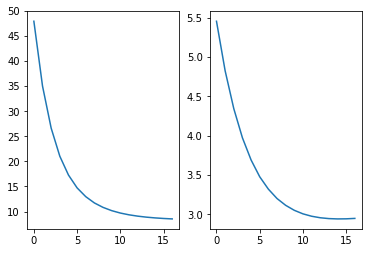

In [29]:
fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(value_obj_values[:final_iter+1])

ax = fig.add_subplot(122)
ax.plot(policy_obj_values[:final_iter+1])

In [30]:
plotting.show_graph(tf.get_default_graph())